In [31]:
import cv2
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt

from math import degrees, radians
from skimage.draw import line_nd
from skimage.color import gray2rgb, rgb2gray

import sys
import numpy as np
import ipywidgets as widgets
np.set_printoptions(threshold=sys.maxsize)

Funkcje pomocnicze

In [32]:
def add_padding(image, color=(0, 0, 0)):
    padding = int(image.shape[0]/2)
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=color)
    return padded_image


Wczytanie obrazu

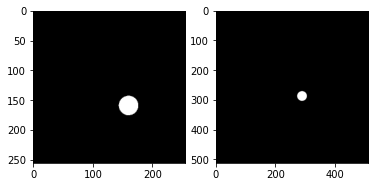

In [33]:
def choose_file():
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filename = filedialog.askopenfilename(initialdir=".", title="Wybierz obraz", filetypes=(("jpeg files", ".jpg"), ("all files", ".")))
    %gui tk
    # root.destroy()
    return filename

filename = choose_file()
# filename = "tomograf-obrazy/kolo.jpg"
img = cv2.imread(filename, 0)
img = cv2.resize(img, (256,256))
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# Change coloring from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

padded_img = add_padding(img)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, cmap="gray")
ax2.imshow(padded_img, cmap="gray")


In [34]:
def calculate_position(r, angle, offset=0):
    angle_rad = np.radians(angle + offset)
    return int(r * np.cos(angle_rad) + r), int(r * np.sin(angle_rad) + r)

In [35]:
def bresenham(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

def radon_lines(emitter, detectors):
    # return [bresenham(emitter[0], emitter[1], x1, y1) for (x1, y1) in detectors]
    return bresenham(emitter[0], emitter[1], detectors[0], detectors[1])

In [43]:
def sinogram(image, radius, angle_range, alpha, detectors):
    number_of_scans = int(360 / alpha)
    sinogram = np.zeros((number_of_scans, detectors))

    for i in range(number_of_scans):
        angle = alpha * i 
        emitter_pos = calculate_position(radius, angle)
        detectors_positions = [
            calculate_position(radius,
                               angle,
                               np.degrees(np.pi - np.radians(angle_range) / 2 + j * (np.radians(angle_range) / (detectors - 1)))) for j in range(detectors)
        ]
        
        for j, detector_pos in enumerate(detectors_positions):
            line_sum = 0
            rows, cols = radon_lines(emitter_pos, detector_pos)
            for x, y in zip(rows, cols):
                line_sum += image[x-1][y-1]
            sinogram[i][j] = line_sum / len(rows)

    # return np.swapaxes(sinogram, 0, 1)
    return sinogram

In [45]:

# Function to update plot based on sliders
def update_plot(angle):
    s = sinogram(padded_img, radius, angle_range, angle, number_of_detectors)
    plt.imshow(s, cmap='gray')
    plt.title(f'Sinogram (Angle: {angle})')
    plt.colorbar()
    plt.show()

In [49]:
number_of_detectors = padded_img.shape[0]
number_of_scans = number_of_detectors//2
emitter_change_angle = 1
radius = padded_img.shape[0]//2
angle_range = 270

angle_slider = widgets.FloatSlider(min=1, max=4, step=emitter_change_angle, value=1, description='Angle')



# s = sinogram(padded_img, radius, angle_range, emitter_change_angle, number_of_detectors)
# plt.imshow(s, cmap='gray')

interactive_plot = widgets.interactive(update_plot, angle=angle_slider)
display(interactive_plot)

# sinogram = radon_transform(padded_img, number_of_scans, number_of_detectors, angle_range)
# plt.imshow(sinogram, cmap='gray')

interactive(children=(FloatSlider(value=1.0, description='Angle', max=4.0, min=1.0, step=1.0), Output()), _dom…

In [50]:
def inverse_radon(sinogram, radius, angle_range, alpha, detectors):
    width = height = 2 * radius
    image = np.zeros((width, height))

    for i in range(sinogram.shape[0]):  # Iterate over angles
        angle = alpha * i
        emitter_pos = calculate_position(radius, angle)

        for j in range(detectors):  # Iterate over detectors
            detector_pos = calculate_position(radius, angle, np.degrees(np.pi - np.radians(angle_range) / 2 + j * (np.radians(angle_range) / (detectors - 1))))
            line = bresenham(emitter_pos[0], emitter_pos[1], detector_pos[0], detector_pos[1])

            for x, y in zip(line[0], line[1]):  # Iterate over line points
                image[x-1, y-1] += sinogram[i, j]

    image /= np.pi / sinogram.shape[0]  # Normalize by dividing by the angle step size

    return image

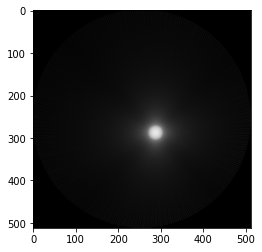

In [51]:
# Usage example:
reconstructed_image = inverse_radon(s, radius, angle_range, emitter_change_angle, number_of_detectors)
# output = inverse_radon(padded_img.shape, s, angle_range)
plt.imshow(reconstructed_image, cmap="gray")